In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

In [3]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True
)
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
train_dataset = tf.data.Dataset.from_generator(lambda: train,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
train_dataset = train_dataset.repeat()


validation_dataset = tf.data.Dataset.from_generator(lambda: validation,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
validation_dataset = validation_dataset.repeat()


test_dataset = tf.data.Dataset.from_generator(lambda: test,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
test_dataset = test_dataset.repeat()

In [5]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [6]:
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

In [7]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 45, 45, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 45, 45, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 45, 45, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 45, 45, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 23, 23, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 23, 23, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 23, 23, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 23, 23, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 12, 12, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 12, 12, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 6, 6, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 6, 6, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 6, 6, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 6, 6, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [8]:
    resnet_model = Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.0009)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [12]:
r = resnet_model.fit(train_dataset,
          epochs=30,
          validation_data=validation_dataset,
          class_weight=class_weight,
          steps_per_epoch=150,
          validation_steps=25)


Epoch 1/30
150/150 [==============================] - 385s 3s/step - loss: 0.1203 - accuracy: 0.8633 - precision: 0.9560 - recall: 0.8595 - val_loss: 1.0243 - val_accuracy: 0.5200 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 2/30
150/150 [==============================] - 375s 3s/step - loss: 0.1240 - accuracy: 0.8750 - precision: 0.9545 - recall: 0.8729 - val_loss: 0.5184 - val_accuracy: 0.8000 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/30
150/150 [==============================] - 379s 3s/step - loss: 0.1069 - accuracy: 0.8833 - precision: 0.9625 - recall: 0.8750 - val_loss: 1.2892 - val_accuracy: 0.4400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
150/150 [==============================] - 375s 2s/step - loss: 0.1138 - accuracy: 0.8733 - precision: 0.9658 - recall: 0.8645 - val_loss: 1.0466 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.1667
Epoch 5/30
150/150 [==============================] - 373s 2s/step - loss: 0.1170 - accuracy

Text(0.5, 1.0, 'Accuracy Evolution')

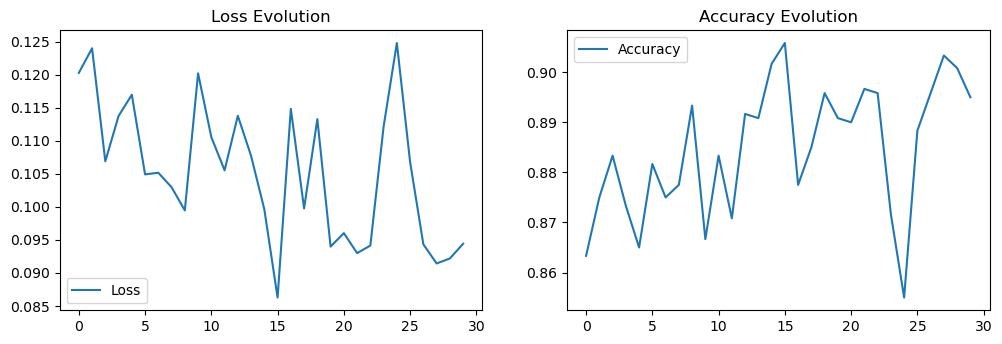

In [13]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [14]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 88s 141ms/step - loss: 0.4139 - accuracy: 0.8029 - precision: 0.9211 - recall: 0.7487
Test Accuracy: 80.29%
652/652 [==============================] - 420s 644ms/step - loss: 0.4869 - accuracy: 0.7876 - precision: 0.9846 - recall: 0.7254
Train Accuracy: 78.76%


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

pred = resnet_model.predict(test)

conf_mat = confusion_matrix(test.classes, pred > 0.5)
print(conf_mat)

class_report = classification_report(test.classes, pred > 0.5, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print(class_report_df)


624/624 [==============================] - 108s 169ms/step
[[215  19]
 [105 285]]
              precision    recall  f1-score     support
0              0.671875  0.918803  0.776173  234.000000
1              0.937500  0.730769  0.821326  390.000000
accuracy       0.801282  0.801282  0.801282    0.801282
macro avg      0.804688  0.824786  0.798749  624.000000
weighted avg   0.837891  0.801282  0.804394  624.000000


In [16]:
resnet_model.save('my_model_rs.h5')
print("done")

done


In [17]:
#65.54/61.39
#80.93/81.46